In [4]:
""" Import Pacakges """
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

ImportError: cannot import name 'StarndardScaler' from 'sklearn.preprocessing' (/home/max/anaconda3/envs/challenge2/lib/python3.8/site-packages/sklearn/preprocessing/__init__.py)

In [ ]:
""" Import data from csv file """

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import data from csv file 
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

df_original = df.copy()

train_df = df.sample(frac=0.8, random_state=101)
validate_df = df.drop(train_df.index)

train_df_original = train_df.copy()
validate_df_original = validate_df.copy()
test_df_original = test_df.copy()

In [ ]:
""" Preprocessing data """

# Dealing the Discrete data
# Translating discrete data into number

discrete_tags = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope",
                 "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
                 "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual",
                 "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir",
                 "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
                 "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition"]

# divide data into discrete and continuous
train_df_continuous = train_df.drop(columns=discrete_tags)
train_df_discrete = train_df[discrete_tags]

# Removing columns with more than 50% missing values
rows_of_data = train_df.shape[0]
missing_values = train_df.isna().sum().to_dict()

for i in missing_values:
    if missing_values[i] > rows_of_data/2:
        if i in discrete_tags:
            train_df_discrete = train_df_discrete.drop(columns=i)
        else:
            train_df_continuous = train_df_continuous.drop(columns=i)

# train_df_discrete = pd.get_dummies(
#     train_df_discrete, columns=discrete_tags, dtype='int')
# validate_df_discrete = pd.get_dummies(
#     validate_df_discrete, columns=discrete_tags, dtype='int')
# test_df_discrete = pd.get_dummies(
#     test_df_discrete, columns=discrete_tags, dtype='int')

# # dealing with discrete data with missing columns
# columns = Union(train_df_discrete.columns.tolist(),
#                 validate_df_discrete.columns.tolist())
# columns = Union(columns, test_df_discrete.columns.tolist())

# for tags_missing in Complement(columns, train_df_discrete.columns.tolist()):
#     train_df_discrete[tags_missing] = 0

# for tags_missing in Complement(columns, validate_df_discrete.columns.tolist()):
#     validate_df_discrete[tags_missing] = 0

# for tags_missing in Complement(columns, test_df_discrete.columns.tolist()):
#     test_df_discrete[tags_missing] = 0

# train_df = train_df_continuous.join(train_df_discrete)
# validate_df = validate_df_continuous.join(validate_df_discrete)
# test_df = test_df_continuous.join(test_df_discrete)

# train_df_discrete['SalePrice'] = train_df_original['SalePrice']

# print("discrete columns: ", columns)

discrete columns:  ['RoofMatl_Tar&Grv', 'BsmtFinType1_BLQ', 'LotConfig_Inside', 'GarageFinish_Fin', 'Exterior2nd_Other', 'Functional_Min2', 'GarageFinish_RFn', 'PoolQC_Ex', 'SaleType_Oth', 'SaleType_ConLI', 'BldgType_2fmCon', 'RoofMatl_ClyTile', 'Exterior2nd_AsphShn', 'PavedDrive_P', 'RoofMatl_Roll', 'SaleType_CWD', 'Exterior1st_WdShing', 'Neighborhood_NWAmes', 'SaleType_ConLD', 'HeatingQC_Gd', 'GarageType_Basment', 'BsmtFinType1_Unf', 'Condition1_RRNn', 'HouseStyle_1Story', 'BldgType_Twnhs', 'Electrical_SBrkr', 'MasVnrType_Stone', 'Electrical_Mix', 'MasVnrType_BrkFace', 'Exterior2nd_HdBoard', 'Foundation_BrkTil', 'ExterCond_Ex', 'HeatingQC_Po', 'Alley_Grvl', 'Fence_GdPrv', 'BsmtFinType1_LwQ', 'BsmtCond_Fa', 'Exterior1st_MetalSd', 'HouseStyle_2.5Fin', 'BsmtFinType2_BLQ', 'GarageQual_Fa', 'Neighborhood_OldTown', 'FireplaceQu_Gd', 'BsmtCond_Gd', 'GarageQual_Gd', 'MiscFeature_Shed', 'Exterior2nd_Stucco', 'Condition2_Norm', 'Neighborhood_ClearCr', 'Neighborhood_NoRidge', 'Condition1_RRAn',

In [ ]:
""" Processing data """
# getting correlation between each column

# selecting continuous data
train_df_corr_continuous = train_df_continuous.corr(numeric_only=True)
corr_result_continuous = train_df_corr_continuous['SalePrice']

tags_to_use = []
for i in range(corr_result_continuous.size):
    if (corr_result_continuous[i] >= 0.6):
        if (corr_result_continuous != "SalePrice"):
            tags_to_use.append(corr_result_continuous.index[i])

# selecting discrete data
sigmas = []
for i in discrete_tags:
    discrete_data_in_column = train_df_discrete[i].unique().tolist()
    y = [train_df[train_df[i] == discrete_datum]["SalePrice"].mean()
         for discrete_datum in discrete_data_in_column]
    sigma = np.std(y)
    sigmas.append(sigma, i)

# selected_discrete_tags = sigmas.sort(key=lambda x,y: x[0], reverse=True)
selected_discrete_tags = sorted(sigmas, key=lambda x: x[0])[:10]
print("selected discrete tags", selected_discrete_tags)

train_df_discrete = train_df_discrete[selected_discrete_tags]

train_df_discrete = pd.get_dummies(
    train_df_discrete, columns=selected_discrete_tags, dtype=np.int64)

print("all selected tags: ", train_df_continuous.columns.tolist() +
      train_df_discrete.column.tolist())

0it [00:00, ?it/s]

49it [00:57,  1.18s/it]
/home/max/anaconda3/envs/challenge2/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


best_tuple:  (0.7500000000000001, 0.7500000000000001)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
y_train_df = train_df["SalePrice"]
y_validate_df = validate_df["SalePrice"]

min_tuple = (0.15, 0.15)
min_degree = 1
min_data_sum = 10e20

# final_tags_to_drop = []
final_tags_to_use = []

for x, y in tqdm(itertools.product(np.arange(0.15, 0.8, 0.1), np.arange(0.15, 0.8, 0.1))):
    # print("x,y: ", x, y)
    # use correlation to select continuous tags
    tags_to_drop = []

    here_train_df = train_df.copy()
    here_validate_df = validate_df.copy()
    here_test_df = test_df.copy()

    """ Post-processing data """
    for i in here_train_df.columns:
        if i == "SalePrice":
            continue

        if i not in tags_to_use:
            tags_to_drop.append(i)
        else:
            # Replace NaN with mean value
            here_train_df[i] = here_train_df[i].fillna(here_train_df[i].mean())
            here_validate_df[i] = here_test_df[i].fillna(
                here_test_df[i].mean())
            here_test_df[i] = here_test_df[i].fillna(here_test_df[i].mean())

    tags_to_drop_with_saleprice = tags_to_drop.copy() + ["SalePrice"]
    here_train_df = here_train_df.drop(columns=(tags_to_drop_with_saleprice))
    here_validate_df = here_validate_df.drop(
        columns=(tags_to_drop_with_saleprice))
    here_test_df = here_test_df.drop(columns=tags_to_drop)

    # Standardize data

    # here_train_df = here_train_df[-1:] + here_train_df[:-1]
    # here_validate_df = here_validate_df[-1:] + here_validate_df[:-1]
    # here_test_df = here_test_df[-1:] + here_test_df[:-1]

    if here_train_df.columns.tolist() == here_validate_df.columns.tolist() and here_validate_df.columns.tolist() == here_test_df.columns.tolist():
        pass
    else:
        print("invalid data")
        print("train_df: ", len(here_train_df.columns.tolist()))
        print("validate_df: ", len(here_validate_df.columns.tolist()))
        print("test_df: ", len(here_test_df.columns.tolist()))

    scaler = StandardScaler()
    here_train_df = scaler.fit_transform(here_train_df)
    here_validate_df = scaler.transform(here_validate_df)
    here_test_df = scaler.transform(here_test_df)

    """ Fit models """
    # Linear Regression
    regressor = LinearRegression()
    regressor.fit(here_train_df, y_train_df)
    validate_df_predict_lr = regressor.predict(here_validate_df)

    # SGD Regressor
    sgd_regressor = SGDRegressor()
    sgd_regressor.fit(here_train_df, y_train_df)
    validate_df_predict_sgd = sgd_regressor.predict(here_validate_df)

    # Polynomial Regression
    min_degree = 10
    min_value = 10e20

    for polynomial_degree in range(1, 4):
        poly_reg = PolynomialFeatures(degree=polynomial_degree)
        train_df_poly = poly_reg.fit_transform(here_train_df)
        poly_regressor = LinearRegression().fit(train_df_poly, y_train_df)

        validate_df_poly = PolynomialFeatures(
            degree=polynomial_degree).fit_transform(here_validate_df)
        polynomial_predict = poly_regressor.predict(validate_df_poly)
        poly_mean_square = mean_squared_error(
            y_validate_df, polynomial_predict)

        if poly_mean_square < min_value:
            min_value = poly_mean_square
            min_degree = polynomial_degree

    """ Evaluate models """
    lr_mean_square = mean_squared_error(y_validate_df, validate_df_predict_lr)
    sgd_mean_square = mean_squared_error(
        y_validate_df, validate_df_predict_sgd)
    # poly_mean_square = mean_squared_error(y_validate_df, polynomial_predict)
    # print("root mean square(LR): ", '{:,}'.format(lr_mean_square))
    # print("root mean square(SGD): ", '{:,}'.format(sgd_mean_square))
    # print("root mean square(Poly): ", '{:,}'.format(poly_mean_square))
    if (lr_mean_square+sgd_mean_square+min_value < min_data_sum):
        min_data_sum = lr_mean_square+sgd_mean_square+poly_mean_square
        min_tuple = (x, y)
        final_tags_to_use = tags_to_use

print("best_tuple: ", min_tuple)

tags_to_drop = []

""" Evaluate models """
for i in train_df.columns:
    if i == "SalePrice":
        continue
        if i not in tags_to_use:
            tags_to_drop.append(i)
        else:
            # Replace NaN with mean value
            train_df[i] = train_df[i].fillna(train_df[i].mean())
            validate_df[i] = validate_df[i].fillna(validate_df[i].mean())
            test_df[i] = test_df[i].fillna(test_df[i].mean())

train_df = train_df.drop(columns=tags_to_drop)
validate_df = validate_df.drop(columns=tags_to_drop)
test_df = test_df.drop(columns=tags_to_drop)
# Linear Regression
""" Fit models """
# Linear Regression
regressor_lr = LinearRegression()
regressor_lr.fit(here_train_df, y_train_df)
predict_validate_lr = regressor_lr.predict(validate_df)

# SGD Regressor
sgd_regressor = SGDRegressor()
sgd_regressor.fit(here_train_df, y_train_df)
predict_validate_sgd = sgd_regressor.predict(validate_df)

# Polynomial Regression
poly_reg = PolynomialFeatures(degree=min_degree)
train_df_poly = poly_reg.fit_transform(here_train_df)
poly_regressor = LinearRegression().fit(train_df_poly, y_train_df)
predict_validate_poly = poly_regressor.predict(validate_df)

print("root mean square(LR): ", '{:,}'.format(
    mean_squared_error(y_validate_df, predict_validate_lr)))
print("root mean square(SGD): ", '{:,}'.format(
    mean_squared_error(y_validate_df, predict_validate_sgd)))
print("root mean square(Poly): ", '{:,}'.format(
    mean_squared_error(y_validate_df, predict_validate_poly)))

In [ ]:
""" Train model """

' Train model '

In [ ]:
# """ Predict """
# ## Linear Regression
# test_df_predict = regressor.predict(test_df)
# # save the result to csv file
# dataframe_result = pd.DataFrame({'Id': test_df_original.Id, 'SalePrice': test_df_predict})
# dataframe_result.to_csv('result_lr.csv', index=False)

# ## SGD Regressor
# test_df_predict = sgd_regressor.predict(test_df)
# # save the result to csv file
# dataframe_result = pd.DataFrame({'Id': test_df_original.Id, 'SalePrice': test_df_predict})
# dataframe_result.to_csv('result_sgd.csv', index=False)

/home/max/anaconda3/envs/challenge2/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

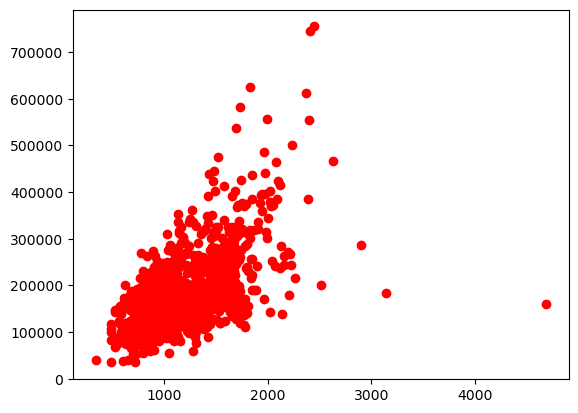

In [ ]:
""" Visualize """
import matplotlib.pyplot as plt
# visualize the training set results
plt.scatter(train_df["1stFlrSF"], y_train_df, color='red')
plt.plot(train_df["1stFlrSF"], regressor.predict(train_df), color='blue')
plt.title('Environment vs SalesPrice (trainning set)')
plt.xlabel("Environment")
plt.ylabel("Sales Price")
plt.show()

# visualize the test set results
plt.scatter(test_df["1stFlrSF"], y_test_df, color='red')
plt.plot(test_df["1stFlrSF"], regressor.predict(test_df), color='blue')
plt.title('Environment vs SalesPrice (test set)')
plt.xlabel("Environment")
plt.ylabel("Sales Price")
plt.show()